# K-Food Image Classification

### 1. Library & Setting

In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

### 2. Data augmentation

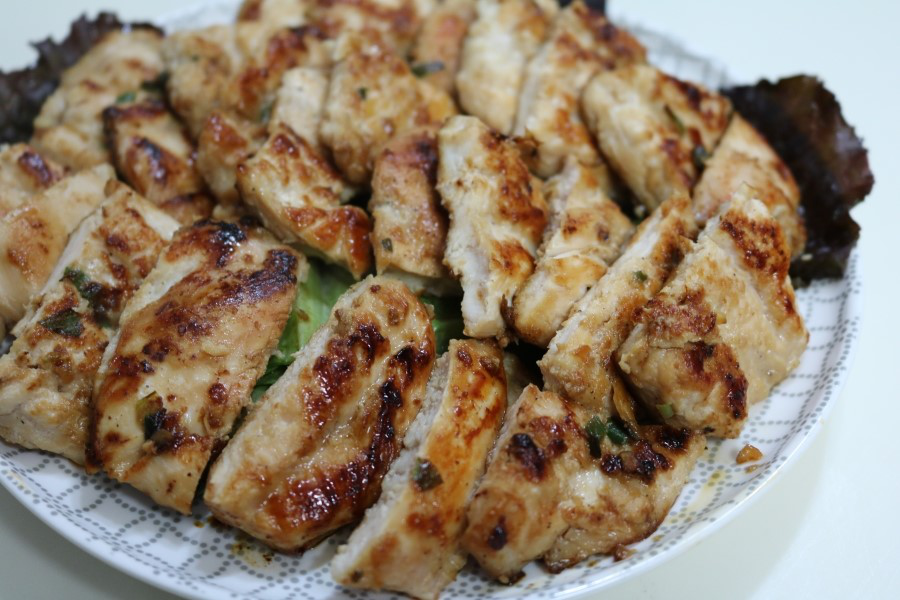

In [2]:
# 임의의 이미지 열어보기
image_path = './kfood/구이/구이/갈비구이/Img_000_0000.jpg'
PIL.Image.open(image_path)

In [3]:
# Image를  스트링으로 읽기
image_string = tf.io.read_file(image_path)

In [4]:
# 이미지 3개의 채널을 갖는 텐서로 변환
image = tf.image.decode_jpeg(image_string,channels=3)

In [5]:
# 데이터 원본과 증강한 이미지 시각화 함수
def visualize(original, augmented):
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

#### 2.1 이미지 좌우반전

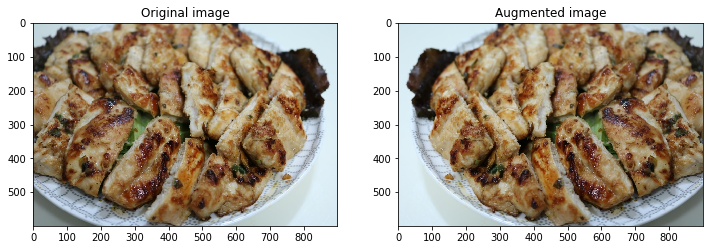

In [6]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### 2.2 이미지 회색조로 표시

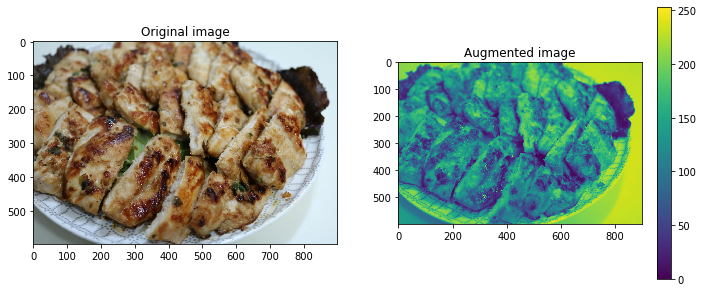

In [7]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

#### 2.3 이미지 채도 조정

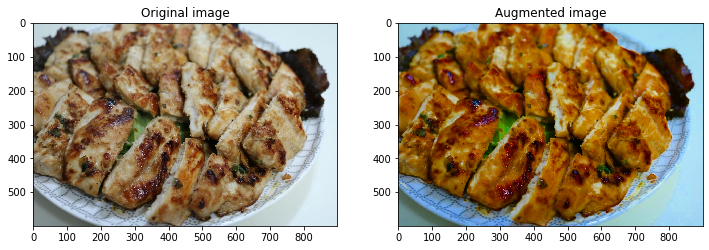

In [8]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 2.4 이미지 밝기 조정

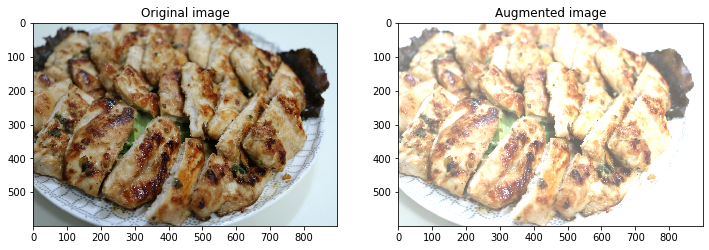

In [9]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 2.5 이미지 90도 회전

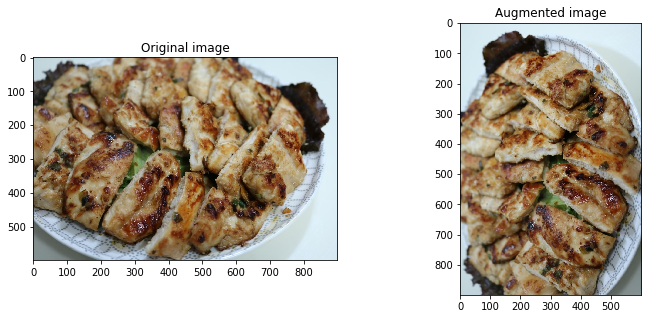

In [10]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### 2.6 이미지 센터 크롭

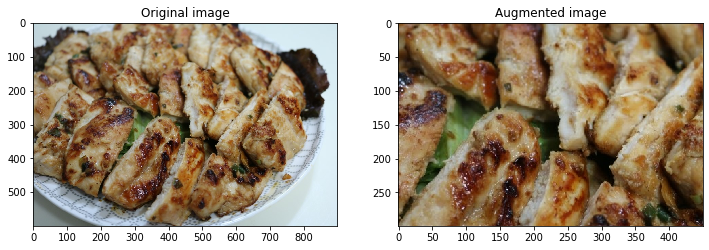

In [11]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### 3. Augment a dataset and train a model with it

In [12]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /Users/parksanghee/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [13]:
dataset

{'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [14]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [15]:
num_train_examples

60000

In [16]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label

In [17]:
def augment(image,label):  
    image,label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    return image,label

In [18]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [19]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [20]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [21]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [22]:
def make_model():
    
    model = tf.keras.Sequential([
                                 layers.Flatten(input_shape=(28, 28, 1)),
                                 layers.Dense(4096, activation='relu'),
                                 layers.Dense(4096, activation='relu'),
                                 layers.Dense(10)
  ])
    model.compile(optimizer = 'adam',
                  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    return model

In [23]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 4s 111ms/step - loss: 0.7616 - accuracy: 0.7671 - val_loss: 0.4558 - val_accuracy: 0.8646
Epoch 2/50
32/32 [==============================] - 3s 104ms/step - loss: 0.1914 - accuracy: 0.9365 - val_loss: 0.3081 - val_accuracy: 0.9101
Epoch 3/50
32/32 [==============================] - 3s 104ms/step - loss: 0.0720 - accuracy: 0.9751 - val_loss: 0.2690 - val_accuracy: 0.9258
Epoch 4/50
32/32 [==============================] - 3s 105ms/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.2946 - val_accuracy: 0.9270
Epoch 5/50
32/32 [==============================] - 3s 105ms/step - loss: 0.0088 - accuracy: 0.9985 - val_loss: 0.2987 - val_accuracy: 0.9316
Epoch 6/50
32/32 [==============================] - 3s 106ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.3416 - val_accuracy: 0.9260
Epoch 7/50
32/32 [==============================] - 3s 107ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.3731 - val_accuracy: 0.9211
Epoch 

KeyboardInterrupt: 

In [24]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 4s 113ms/step - loss: 2.4190 - accuracy: 0.2563 - val_loss: 1.2284 - val_accuracy: 0.6267
Epoch 2/50
32/32 [==============================] - 4s 113ms/step - loss: 1.4613 - accuracy: 0.4922 - val_loss: 0.7679 - val_accuracy: 0.7928
Epoch 3/50
 7/32 [=====>........................] - ETA: 1s - loss: 1.0919 - accuracy: 0.6473

KeyboardInterrupt: 

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

NameError: name 'aug_history' is not defined

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

NameError: name 'aug_history' is not defined